# Convolución de matrices para procesado de imágenes
> Con un enfoque al paradigma funcional de programación en python.

- toc: false
- badges: true
- comments: true
- categories: [python, jupyter, functional programming]
- image: images/convolution/penguin_borders.png

![](../images/convolution/convolutionexample.png)

Una de las aplicaciones más importantes de la convolución de matrices es el procesamiento de imágenes, mediante un proceso iterativo que recorre cada pixel de una imagen, obteniendo valores de los pixeles circundantes y aplicando una transformación a estos datos, se puede obtener información relevante y realzar o mejorar aspectos que no son claramente notorios a simple vista o que son difíciles de procesar sin un tratamiento previo.

En formato digital, una imagen de mapa de bits tiene la estructura de una matriz de dos dimensiones, puede representarse como una función $f(x,y)$ donde $x$ e $y$ nos dan la posición de cada pixel y la función nos devuelve su 'color'. Para visualizar el color de este pixel, se usa un vector de tres valores que representan la intensidad de los colores rojo, verde y azul, cada uno tomando valores desde 0 a 255.

Entonces, la convolución de matrices consiste en la sumatoria de la multiplicación de cada elemento de un kernel predefinido con cada elemento de una sub matriz (sección de una matriz más grande) como se describe en la siguiente ecuación:

$$
g(x,y)=w*f(x,y)={1\over c}\sum_{dx=-a}^{a}\sum_{dy=-b}^{b}w(dx,dy)f(x+dx,y+dy)
$$

Donde $f(x,y)$ es la imagen original, $w$ el kernel de filtrado y $g(x,y)$ la imagen resultante del proceso de convolución, $a$ y $b$ representan la distancia desde el elemento central del kernel hacia los bordes, de modo que definen el tamaño del kernel, en este trabajo usaremos una matriz de $3\times3$, por lo que $dx$ y $dy$ tomarán valores discretos en el rango $[-1,1]$ en este caso. La variable $c$ es el factor de normalización, su valor es la suma de los elementos del kernel, lo que nos permite mantener el valor promedio de nivel de color.

Esta será la ecuación que desarrollaremos de manera funcional, para luego comprobar su funcionamiento con algunas matrices kernel conocidas para evaluar los resultados que obtengamos.

Para esto usaremos las siguientes bibliotecas que importamos a continuación: Pillow, numpy, matplotlib y también usaremos algunas funciones de functools.


In [1]:
import matplotlib.image as img
from PIL import Image
from functools import reduce
import numpy as np

## Definición de funciones

Uno de los principios de la programación funcional consiste en crear funciones que se asemejen a funciones matemáticas, esto es, que los datos que retornen representen una transformación de sus datos de entrada, sin causar modificaciones en otras partes del programa ni verse afectadas por otros factores externos. Para esto, usaremos las funciones `lambda` de python, que ayudarán a mantener una buena legibilidad.

Como la matriz de la imagen contiene vectores de tres elementos, tendremos que definir una función para realizar la multiplicación de un entero con una tupla, usando funciones lambda tendremos:

In [2]:
# multiplicación de un entero y una tupla
mult_int_tuple = lambda i, a, b, c : (i*a, i*b, i*c)

Como vemos, esta función toma cuatro argumentos y los devuelve transformados, sin realizar asignaciones de variables. En programación funcional no se usan variables, sino funciones que devuelven valores constantes, por tanto no pueden hacerse asignaciones a estas una vez definidas.

Para evitarnos la necesidad de hacer asignaciones de variables, haremos uso en muchos casos de una característica de python: *unpacking* que consiste en realizar asignaciones a tuplas, de modo que se pueden hacer asignaciones de varios valores a la vez o incluso recibir en una tupla los valores de una función que devuelva más de un valor. Pero dijimos que no usaríamos asignaciones, así que usaremos otro aspecto del *unpacking*, en este caso al llamar a funciones, en lugar de llamar a la función `mult_int_trip` con cuatro argumentos, lo haremos con dos: un entero y una tupla de tres elementos, para esto, llamaremos a la función con la siguiente sintaxis:
```
mult_int_trip(i, *t)
```
Donde `i` es un entero y `t` una tupla, nótese que el símbolo de asterisco (`*`) delante de `t` nos permite mapear los tres valores de la tupla `t` en las variables `a`, `b` y `c` de la función, de no incluirlo, tendríamos errores en la ejecución, ya que la función espera cuatro argumentos y estaríamos enviando sólo dos.

De forma similar a la anterior, definiremos otras funciones que requeriremos en el futuro.

In [3]:
# división de una tupla por un entero
div_tuple_int = lambda i, a, b, c : (a/i, b/i, c/i)

# suma de un entero a los elementos de una tupla
sum_tuple_int = lambda i, a, b, c : (a+i, b+i, c+i)

# suma de dos tuplas
sum_tuples = lambda a, b : (a[0]+b[0], a[1]+b[1], a[2]+b[2])

Además tomaremos algunos otros detalles en cuenta, ya que se trata de colores formados por tres valores (rojo, verde y azul), tendremos que controlar que no se salgan del rango $[0, 255]$. para esto crearemos las siguientes funciones:

In [4]:
ib = lambda x : 0 if x < 0 else 255 if x > 255 else x
in_bounds = lambda x, y, z : (ib(x), ib(y), ib(z))

La primera función, `ib`, recibe un número y comprueba que se encuentre en el rango correcto, si es menor que 0 devolverá 0 y si es mayor que 255 devolverá 255, para los demás casos devolverá el mismo valor de entrada. En la segunda función, realizamos la misma tarea pero para una tupla de tres elementos, haciendo uso de la función `ib` para cada elemento.

## Iteración en programación funcional

La iteración en programación funcional no se realiza usando bucles `for` o `while`, como dijimos antes, no se permite la asignación de variables, y estos bucles suelen depender de la variación de un contador el control de sus iteraciones, en lugar de bucles suele usarse recursividad, pero en este caso usaremos funciones como `map` o `reduce`, que nos permiten aplicar una función a un elemento iterable como una lista o vector, devolviendo otra lista con los valores ya procesados.

En la siguiente imagen podemos ver un ejemplo de la implementación de `map` sobre una lista, el ejemplo muestra la sintaxis de haskell, un lenguaje de programación puramente funcional, pero python también tiene implementada la función `map` que podemos usar de la misma manera.

![](../images/convolution/map.png)

Es así como haremos el recorrido sobre las matrices y sobre toda la imagen que estaremos tratando, pero en este caso, me tomaré una licencia sobre la fórmula de convolución que vimos al principio, en lugar de tomar dos matrices y aplicar la convolución en cada fila y columna, tomaremos dos listas que contengan los mismos elementos, esto sólo por simplicidad, ya que el resultado será exactamente el mismo.

Para esto, definiremos una función que reciba como entrada una imagen y las coordenadas de un pixel y nos devuelva una lista de los pixeles circundantes, el orden es importante, tendremos que mantener el mismo orden en el kernel también, de modo que la correspondencia no se vea afectada.

In [5]:
get_surroundings = lambda image, row, col : \
          [image[row-1][col-1], image[row][col-1], image[row+1][col-1],  \
           image[row-1][col],   image[row][col],   image[row+1][col],    \
           image[row-1][col+1], image[row][col+1], image[row+1][col+1]]

Ya que estaremos aplicando una función a cada elemento de dos listas, también definiremos la función `zipWith`, esta función nos permitirá realizar operaciones de manera directa en dos vectores sin tener que iterar sobre ellos (al menos no de manera explícita).

In [6]:
zipwith_tuples = lambda f, li, lt : [f(i, *t) for (i, t) in zip(li, lt)]

Esta función, toma como argumentos una función `f`, una lista de enteros `li` y una lista de tuplas `lt`, y devuelve una lista que definimos usando la sintaxis de listas de comprensión de python, cuyos elementos son resultado de aplicar la función `f` sobre un par de elementos `i` y `t` que obtendremos de la unión - elemento a elemento - de las listas `li` y `lt`.

Esta unión la realiza la función `zip` que devuelve una lista de tuplas en que el primer elemento pertenece a la primera lista y el segundo a la segunda lista.

## Función convolución

Ahora definimos la función que realizará la convolución como indica la fórmula que vimos anteriormente.
Siendo innecesariamente rigurosos con la programación funcional, podríamos definir nuestra función de convolución de esta forma:

In [7]:
convolution = lambda arri, arrt, factor, offset : sum_tuple_int(offset, *div_tuple_int(factor, *reduce(sum_tuples, zipwith_tuples(mult_int_tuple, arri, arrt))))

Pero para hacerla un poco más legible, me tomaré la libertad de definirla de la siguiente manera:

In [8]:
def convolution(arri, arrt, factor, offset):
    trip = reduce(sum_tuples, zipwith_tuples(mult_int_tuple, arri, arrt))
    trip = div_tuple_int(factor, *trip)
    trip = sum_tuple_int(offset, *trip)
    return trip

De todos modos, aún se cumple que cuando la función sea llamada con los mismos parámetros, devuelva la misma respuesta ya que no realizamos cambios en ninguna variable.

Esta función recibe como parámetros las dos matrices a operar, el factor por el que dividiremos el resultado, y un offset que podremos usar para controlar el brillo que tenga la imagen, si es que después del proceso este varía. Este es un valor que sumaremos a cada color de cada pixel.

Finalmente definimos una función más, donde haremos la iteración por cada pixel de la imagen ejecutando la función `convolution`, esta función recibirá como argumentos una imagen, el kernel que elijamos, el factor y el offset, para devolvernos una nueva imagen procesada.

In [75]:
def make_convolution(image_file, kernel, factor, offset):
    (height, width, dat) = image_file.shape
    image = image_file.tolist()
    image2 = [[[0,0,0] for j in range(width)] for i in range(height)]
    for row in range(1, height-1):
        for col in range(1, width-1):
            arr = get_surroundings(image, row, col)
            arrt = convolution(kernel, arr, factor, offset)
            image2[row][col] = in_bounds(*arrt)
    return image2


Con esto ya estamos listos para probar el código con una imagen y algunos kernels conocidos. primero abriremos una imagen usando la biblioteca `matplotlib` que importamos al principio.

In [82]:
image_file = img.imread("../images/convolution/penguin.jpg")

Usaremos esta fotografía de [Jay Ruzesky](https://wordpress.viu.ca/ruzeskyj) como ejemplo:

![](../images/convolution/penguin.jpg)

## Box blur

Básicamente, este kernel saca un promedio de los pixeles circundantes, nótese que al ser una matriz de unos, se sumarán todos los valores numéricos de los pixeles sin ser modificados, para luego ser divididos por el factor que en este caso es nueve.

In [93]:
box_blur = [1, 1, 1, \
            1, 1, 1, \
            1, 1, 1]
factor = 9
offset = 0

image2 = make_convolution(image_file, box_blur, factor, offset)

La variable `image2` es una matriz de pixeles, así que la convertiremos en una imagen, usando numpy, para que la podamos mostrar, haremos esto con cada imagen.

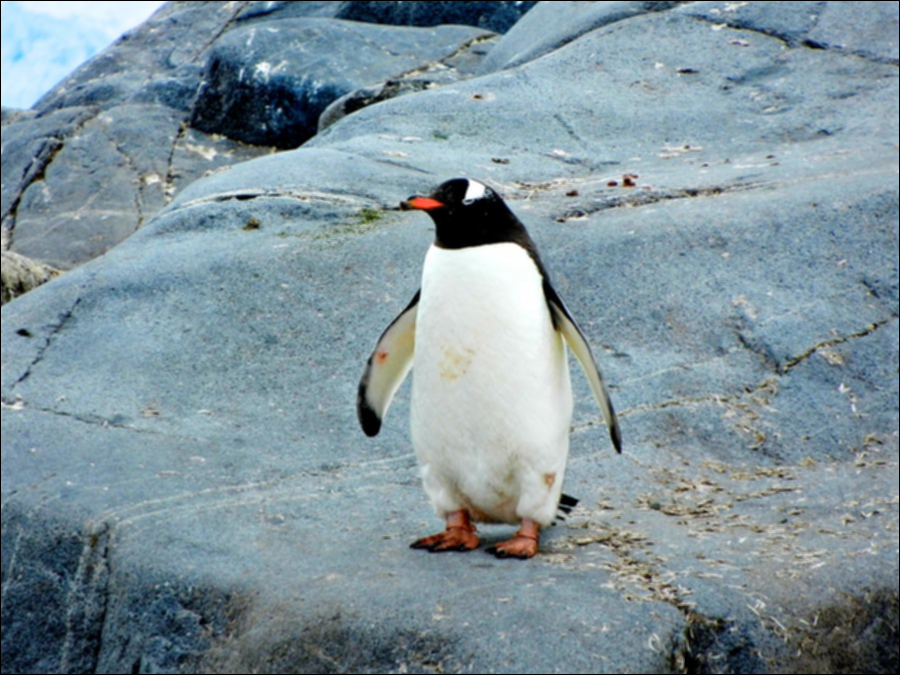

In [94]:
image2_arr = np.asarray(image2, dtype="uint8")
img_file = Image.fromarray(image2_arr, 'RGB')
img_file

Tenemos como resultado una imagen con un filtro blur, quedando un poco más borrosa que la original.

Veamos otros ejemplos.

## Blur Gaussiano

El blur Gaussiano consiste en difuminar una imagen usando la función de Gauss, en este caso por supuesto usamos una aproximación, al estar trabajando con valores discretos.

In [97]:
gaussian_blur = [1, 2, 1, \
                 2, 4, 2, \
                 1, 2, 1]
factor = 16
offset = 0

image2 = make_convolution(image_file, gaussian_blur, factor, offset)

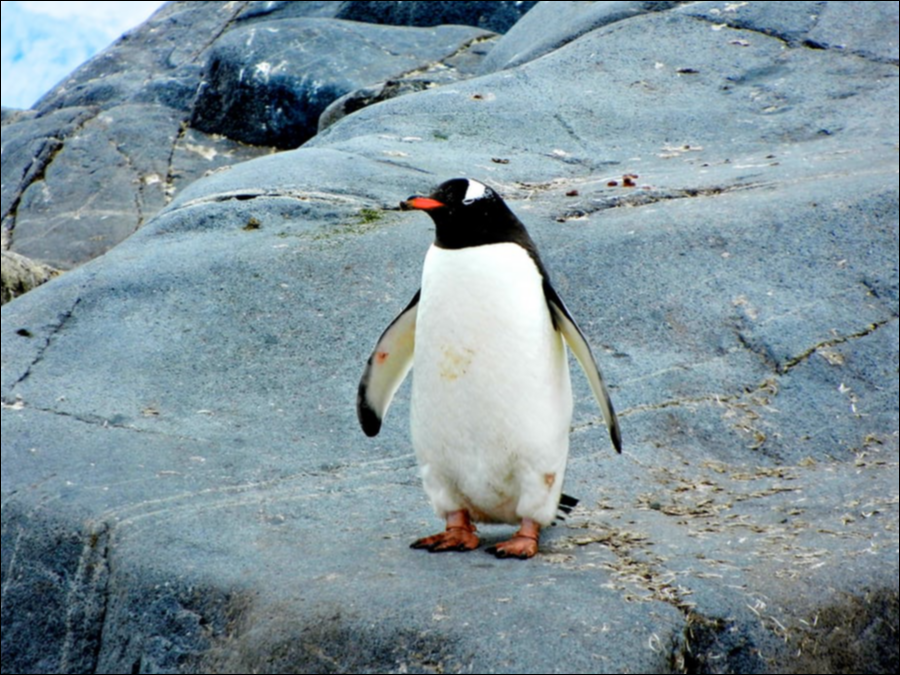

In [98]:
#hide_input
image2_arr = np.asarray(image2, dtype="uint8")
img_file = Image.fromarray(image2_arr, 'RGB')
img_file

## Sharpen

El filtro sharpen hace lo contrario que un filtro blur, en lugar de difuminar la imagen, trata de darle más definición.

In [99]:
sharpen = [ 0, -1,  0, \
           -1,  5, -1, \
            0, -1,  0]
factor = 1
offset = 0

image2 = make_convolution(image_file, sharpen, factor, offset)

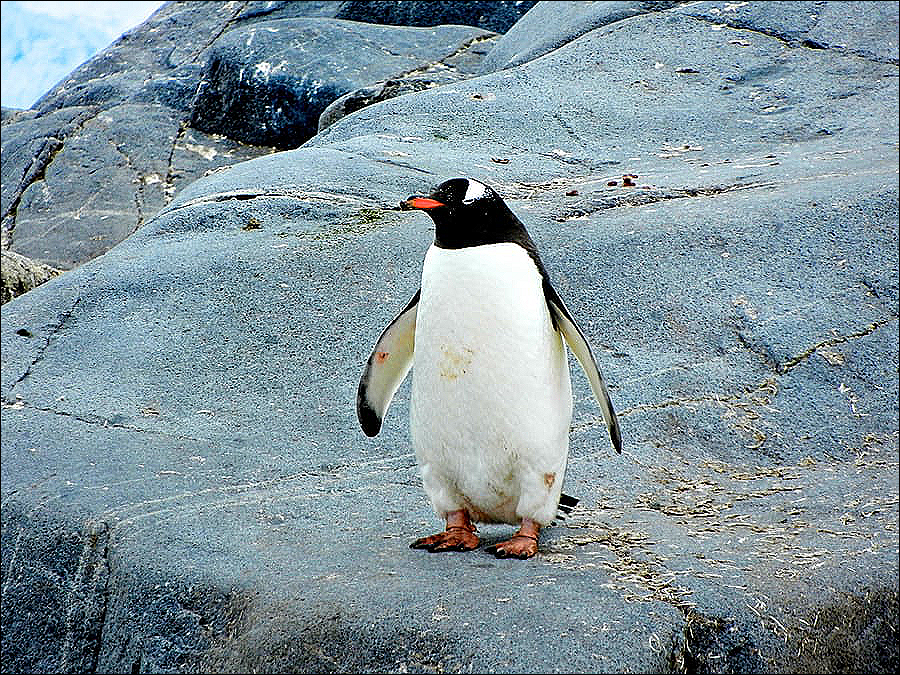

In [100]:
#hide_input
image2_arr = np.asarray(image2, dtype="uint8")
img_file = Image.fromarray(image2_arr, 'RGB')
img_file

## Detección de bordes

Existen varios kernels que, aplicados a una imagen, muestran los bordes de los objetos mostrados en la imagen, basados en la variación del color.

In [101]:
border = [ -1, -1, -1, \
           -1,  8, -1, \
           -1, -1, -1]
factor = 1
offset = 0

image2 = make_convolution(image_file, border, factor, offset)

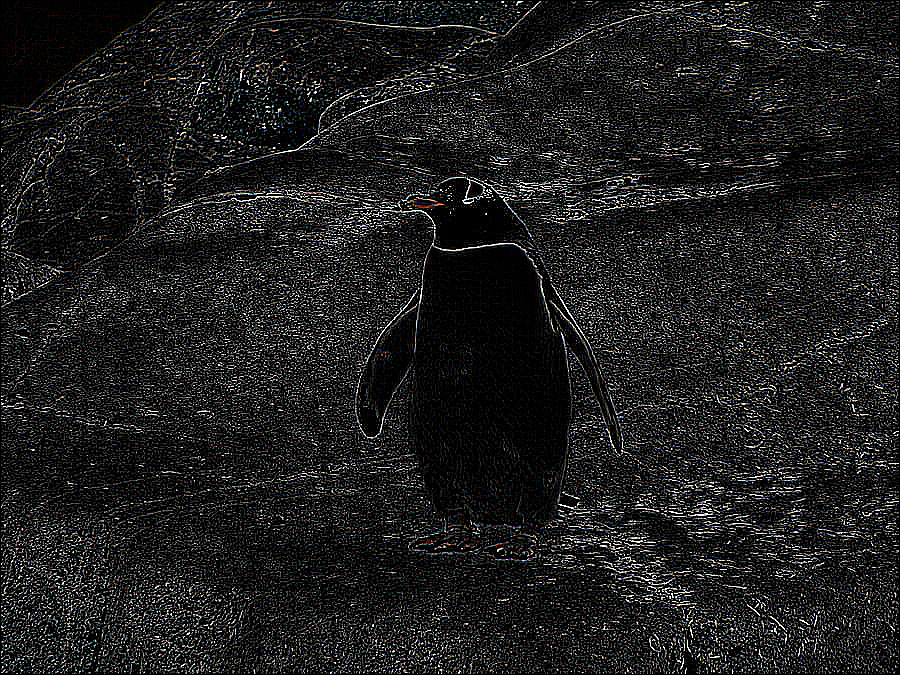

In [102]:
#hide_input
image2_arr = np.asarray(image2, dtype="uint8")
img_file = Image.fromarray(image2_arr, 'RGB')
img_file

Otro ejemplo de detección de bordes:

In [103]:
border2 = [-1, 0, -1, \
            0, 4,  0, \
           -1, 0, -1]
factor = 1
offset = 0

image2 = make_convolution(image_file, border2, factor, offset)

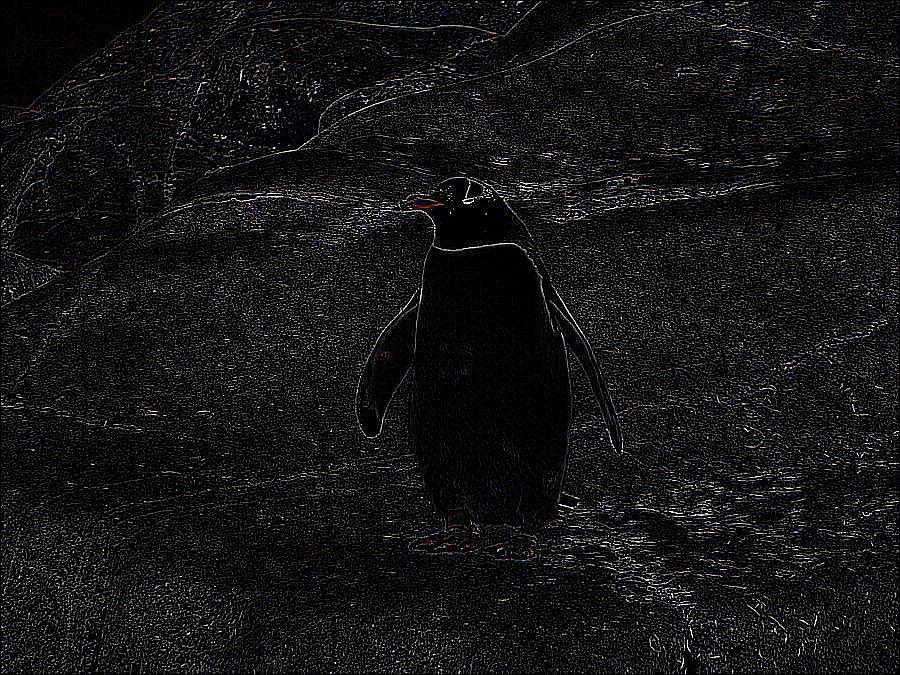

In [104]:
#hide_input
image2_arr = np.asarray(image2, dtype="uint8")
img_file = Image.fromarray(image2_arr, 'RGB')
img_file

## Observaciones

Para imágenes grandes, esta implementación puede llegar a tomar mucho tiempo, una solución empleando programación dinámica podría reducir notoriamente el tiempo de ejecución.

El efecto de los filtros varía notoriamente según el tamaño de la imagen, en imágenes muy grandes su efecto casi no se aprecia, para corregir esto, sería necesario ampliar las dimensiones del kernel.

## Referencias

Giménez Palomares, F., Monsoriu Serrá, J., & Alemany Martínez, E. (2016). Aplicación de la convolución de matrices al filtrado de imágenes. Modelling in Science Education and Learning, 9(1), 97-108. doi:https://doi.org/10.4995/msel.2016.4524

Ludwig, J. (2013). Image convolution. Portland State University.

Patin, F. (2003). An introduction to digital image processing. online]: http://www. programmersheaven. com/articles/patin/ImageProc. pdf.